In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/Users/laurentperrinet/quantic/science/HomeHots/HOTS_clone_laurent/HOTS


In [2]:
import time
def tic():
    global ttic
    ttic = time.time()
def toc():
    print(f'Done in {time.time() - ttic:.3f} s')

# raw dataloader

In [3]:
import tonic 
download = False
#download = True
tic()
dataset = tonic.datasets.NMNIST(save_to='../Data/',
                                  train=True, download=download,
                                 )
toc()

Done in 1.885 s


In [4]:
tic()
events, target = next(iter(dataset))
toc()

Done in 0.001 s


# torch sparse

https://pytorch.org/docs/stable/sparse.html

In [5]:
import torch

In [6]:
events.shape, dataset.ordering

((4636, 4), 'xytp')

In [7]:
events[0, :]

array([   7,   25, 1938,    1], dtype=int32)

In [8]:
from tonic.functional import to_sparse_tensor_pytorch

In [9]:
dataset.sensor_size

(34, 34)

In [10]:
sparse_tensor = to_sparse_tensor_pytorch(events, dataset.sensor_size, dataset.ordering )

In [11]:
sparse_tensor?

Type:        Tensor
String form:
tensor(indices=tensor([[  1938,   2135,   2251,  ..., 304352, 305442, 308046],
           <...>  1.,  1.,  ...,  1., -1.,  1.]),
           size=(308047, 34, 34), nnz=4636, layout=torch.sparse_coo)
Length:      308047
File:        /usr/local/lib/python3.9/site-packages/torch/__init__.py
Docstring:   <no docstring>


In [12]:
sparse_tensor.to_dense().shape

torch.Size([308047, 34, 34])

In [13]:
first_frame = sparse_tensor.to_dense()[0, :, :]

In [14]:
first_frame.min(), first_frame.max()

(tensor(0.), tensor(0.))

# directly by a transform

https://pytorch.org/docs/stable/sparse.html

In [15]:
import tonic 
download = False
tic()
dataset_sparse = tonic.datasets.NMNIST(save_to='../Data/',
                                  train=True, download=download,
                                  transform=tonic.transforms.ToSparseTensor()
                                 )
toc()

Done in 1.876 s


In [16]:
tic()
events, target = next(iter(dataset_sparse))
toc()

Done in 0.002 s


In [17]:
event = events[0]

In [18]:
event?

Type:        Tensor
String form:
tensor(indices=tensor([[  1938,   2135,   2251,  ..., 304352, 305442, 308046],
           <...>  1.,  1.,  ...,  1., -1.,  1.]),
           size=(308047, 34, 34), nnz=4636, layout=torch.sparse_coo)
Length:      308047
File:        /usr/local/lib/python3.9/site-packages/torch/__init__.py
Docstring:   <no docstring>


# building time matrix

In [19]:
tic()
dataset = tonic.datasets.NMNIST(save_to='../Data/',
                                  train=True, download=download,
                                  #transform=tonic.transforms.AERtoVector()
                                 )
toc()

Done in 1.870 s


In [20]:
tic()
events, target = next(iter(dataset))
toc()

Done in 0.001 s


In [21]:
events

array([[     7,     25,   1938,      1],
       [    11,     22,   2135,      1],
       [    11,     21,   2251,      1],
       ...,
       [    19,     23, 304352,      1],
       [     9,     20, 305442,      0],
       [    26,     11, 308046,      1]], dtype=int32)

In [22]:
events.shape, dataset.sensor_size, dataset.ordering

((4636, 4), (34, 34), 'xytp')

In [23]:
events[0, :]

array([   7,   25, 1938,    1], dtype=int32)

In [24]:
events[:, 2] # time in microseconds

array([  1938,   2135,   2251, ..., 304352, 305442, 308046], dtype=int32)

In [25]:
import numpy as np

In [26]:
n_events = events.shape[0]
n_x, n_y = dataset.sensor_size
n_pol = 2
tic()
times = np.zeros((n_events, n_x, n_y, n_pol))
times[np.arange(n_events), events[:, 0], events[:, 1], events[:, 3]] = events[:, 2]
toc()

Done in 0.008 s


In [27]:
import matplotlib.pyplot as plt

In [28]:
idx, idy, idp = 23, 15, 0

In [29]:
times[:, idx, idy, idp]

array([0., 0., 0., ..., 0., 0., 0.])

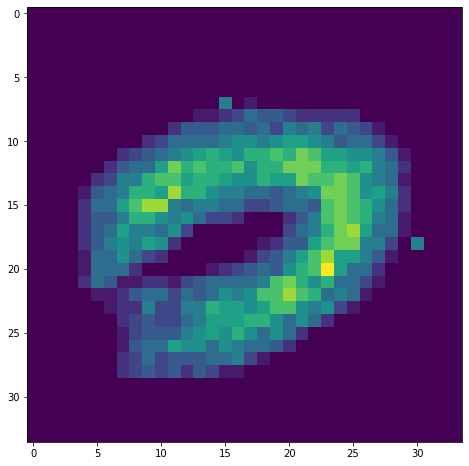

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow((times[:, :, :, idp]>0).sum(axis=(0)))

In [31]:
time_ = times[:, idx, idy, idp]

Text(0.5, 0, 'event #')

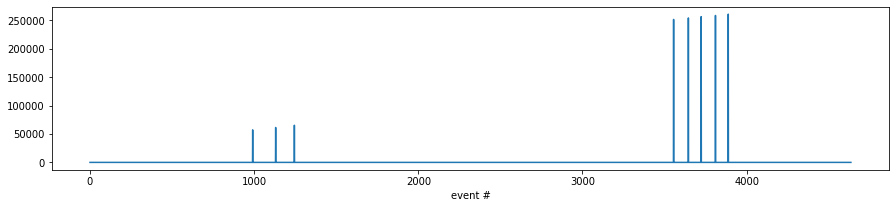

In [32]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time_)
ax.set_xlabel('event #')

# building dt matrix

sur chaque ligne idx, idy, idp, on veut obtenir le temps depuis le dernier event... on peut déjà extraire les spikes:

In [33]:
tic()
events, target = next(iter(dataset))
toc()

Done in 0.001 s


In [34]:
events[:, 2]

array([  1938,   2135,   2251, ..., 304352, 305442, 308046], dtype=int32)

In [35]:
tic()
spikes = np.zeros((n_events, n_x, n_y, n_pol))
spikes[np.arange(n_events), events[:, 0], events[:, 1], events[:, 3]] = 1
toc()

Done in 0.008 s


In [36]:
dt = events[:, 2].copy()
dt[1:] = events[1:, 2] - events[:-1, 2]
dt

array([1938,  197,  116, ..., 1394, 1090, 2604], dtype=int32)

In [37]:
time_ = spikes[:, idx, idy, idp]

Text(0.5, 0, 'event #')

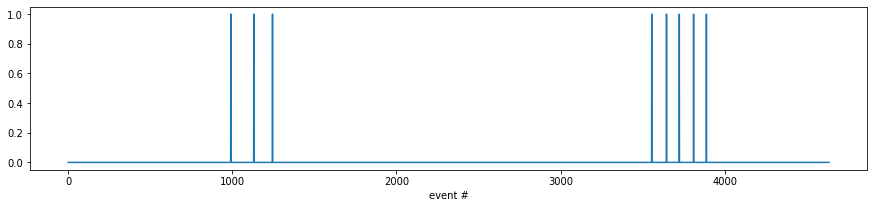

In [38]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time_)
ax.set_xlabel('event #')

# building presynaptic matrix

sur chaque ligne idx, idy, idp, on veut opérer une ODE

In [39]:
tic()
events, target = next(iter(dataset))
toc()

Done in 0.001 s


In [40]:
events[:, 2]

array([  1938,   2135,   2251, ..., 304352, 305442, 308046], dtype=int32)

In [41]:
tic()
spikes = np.zeros((n_events, n_x, n_y, n_pol))
spikes[np.arange(n_events), events[:, 0], events[:, 1], events[:, 3]] = 1
toc()

Done in 0.008 s


In [42]:
dt = events[:, 2].copy()
dt[1:] = events[1:, 2] - events[:-1, 2]
dt

array([1938,  197,  116, ..., 1394, 1090, 2604], dtype=int32)

In [43]:
spikes_ = spikes[:, idx, idy, idp]

Text(0.5, 0, 'event #')

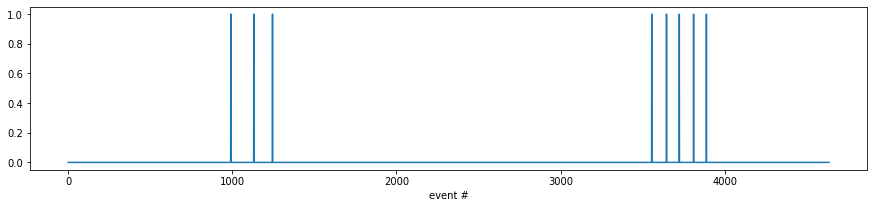

In [44]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(spikes_)
ax.set_xlabel('event #')

In [45]:
timing = events[:, 2].copy()
timing

array([  1938,   2135,   2251, ..., 304352, 305442, 308046], dtype=int32)

In [46]:
ordering = dataset.ordering
x_index = ordering.find("x")
y_index = ordering.find("y")
t_index = ordering.find("t")
p_index = ordering.find("p")
x_index, y_index, t_index, p_index

(0, 1, 2, 3)

In [47]:
tau = 150 * 1000 # time scale in microseconds
sample_space = 1

In [48]:
tic()
Vm = np.zeros((n_events, n_x//sample_space, n_y//sample_space, n_pol))

for i_event in range(n_events):
    if i_event>0:
        #print(np.exp(-(events[i_event, t_index]-events[i_event-1, t_index])/tau))
        Vm[i_event, :, :, :] = Vm[i_event-1, :, :, :] * np.exp(-(events[i_event, t_index]-events[i_event-1, t_index])/tau)

    x_pos = events[i_event, x_index]//sample_space
    y_pos = events[i_event, y_index]//sample_space
    p = events[i_event, p_index]
    
    Vm[i_event, x_pos, y_pos, p] = 1.

toc()

Done in 0.108 s


In [49]:
tic()
Vm = np.zeros((n_events, n_x//sample_space, n_y//sample_space, n_pol))

discount = np.exp(-(events[1:, t_index]-events[:-1, t_index])/tau)

for i_event in range(n_events):
    if i_event>0:
        #print(np.exp(-(events[i_event, t_index]-events[i_event-1, t_index])/tau))
        Vm[i_event, :, :, :] = Vm[i_event-1, :, :, :] * discount[i_event-1]

    x_pos = events[i_event, x_index]//sample_space
    y_pos = events[i_event, y_index]//sample_space
    p = events[i_event, p_index]
    
    Vm[i_event, x_pos, y_pos, p] = 1.

toc()

Done in 0.099 s


In [50]:
discount

array([0.99868753, 0.99922697, 0.99203191, ..., 0.99074972, 0.99275967,
       0.98278982])

In [51]:
tic()
Vm = np.zeros((n_events, n_x//sample_space, n_y//sample_space, n_pol))

discount = np.exp(-(events[1:, t_index]-events[:-1, t_index])/tau)

for i_event in range(n_events):
    if i_event>0:
        #print(np.exp(-(events[i_event, t_index]-events[i_event-1, t_index])/tau))
        Vm[i_event, :, :, :] = Vm[i_event-1, :, :, :] * discount[i_event-1]

    Vm[i_event, events[i_event, x_index]//sample_space, events[i_event, y_index]//sample_space, events[i_event, p_index]] = 1.

toc()

Done in 0.069 s


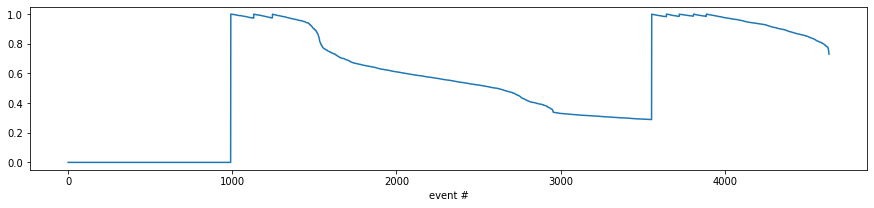

In [52]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(Vm[:, idx, idy, idp])
ax.set_xlabel('event #');

# dataloader with AERtoVector

In [53]:
tic()
pre_dataset = tonic.datasets.NMNIST(save_to='../Data/',
                                  train=False, download=download,
                                  transform=tonic.transforms.AERtoVector()
                                 )
toc()

Done in 0.316 s


In [54]:
next(iter(pre_dataset))

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.29135291, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.29094918, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.28944596, 0.        ,
         0.        ]]),
 0)

In [55]:
tic()
events, target = next(iter(pre_dataset))
toc()

Done in 0.139 s


In [56]:
events.shape

(5783, 2312)

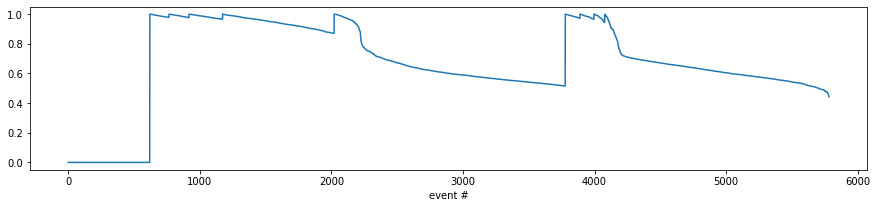

In [57]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(events[:, idx*34 + idy])
ax.set_xlabel('event #');

# sandbox

In [58]:
class ToTo:
    sensor_size = (34, 34)
    ordering = "xytp"    
    
t = ToTo()

In [59]:
t.sensor_size

(34, 34)